In [4]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/mmd_flow_cubature")
import sys
sys.path.append("/home/zongchen/mmd_flow_cubature")
from mmd_flow.distributions import Distribution
from mmd_flow.kernels import gaussian_kernel
from mmd_flow.mmd import mmd_fixed_target
from mmd_flow.gradient_flow import gradient_flow
import mmd_flow.utils
jax.config.update("jax_enable_x64", True)


In [5]:
bandwidth = 1.0
kernel = gaussian_kernel(bandwidth)
covariances = jnp.load('data/mog_covs.npy')
means = jnp.load('data/mog_means.npy')
k = 20
weights = jnp.ones(k) / k


In [6]:
# This is neg exponetial
# 
distribution = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='neg_exp', weights=weights)
true_value = distribution.integral()
print(true_value)

seed_numbers = range(0, 8)  # Adjust this range as needed
particle_num_list = [30, 100, 300, 1000]
step_num_list = [10000, 10000, 30000, 30000]
I_err = {'iid': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'mmd_flow': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'qmc': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'kh': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]}

for e, particle_num in enumerate(particle_num_list):
    for seed in seed_numbers:
        dir_path = f"/home/zongchen/mmd_flow_cubature/results/mmd_flow/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_{step_num_list[e]}__particle_num_{particle_num}__inject_noise_scale_0.1__seed_{seed}/"
        true_value = distribution.integral()
        iid_samples = np.load(dir_path + 'iid_samples.npy')
        mmd_flow_samples = np.load(dir_path + 'mmd_flow_samples.npy')
        qmc_samples = np.load(dir_path + 'qmc_samples.npy')

        I_err['iid'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, iid_samples))
        I_err['iid'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, iid_samples))
        I_err['mmd_flow'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, mmd_flow_samples))
        I_err['mmd_flow'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, mmd_flow_samples))
        I_err['qmc'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, qmc_samples))
        I_err['qmc'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, qmc_samples))

        dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_herding/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__seed_{seed}/"

        kh_samples = np.load(dir_path + 'kernel_herding_samples.npy')
        I_err['kh'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kh_samples))
        I_err['kh'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kh_samples))

0.04081752632448611


In [8]:
I_err['iid'][0] = np.nanmean(I_err['iid'][0], axis=1)
I_err['iid'][1] = np.nanstd(I_err['iid'][1], axis=1) / np.sqrt(I_err['iid'][1].shape[1])
I_err['mmd_flow'][0] = np.nanmean(I_err['mmd_flow'][0], axis=1)
I_err['mmd_flow'][1] = np.nanstd(I_err['mmd_flow'][1], axis=1) / np.sqrt(I_err['mmd_flow'][1].shape[1])
I_err['kh'][0] = np.nanmean(I_err['kh'][0], axis=1)
I_err['kh'][1] = np.nanstd(I_err['kh'][1], axis=1) / np.sqrt(I_err['kh'][1].shape[1])
I_err['qmc'][0] = np.nanmean(I_err['qmc'][0], axis=1)
I_err['qmc'][1] = np.nanstd(I_err['qmc'][1], axis=1) / np.sqrt(I_err['qmc'][1].shape[1])

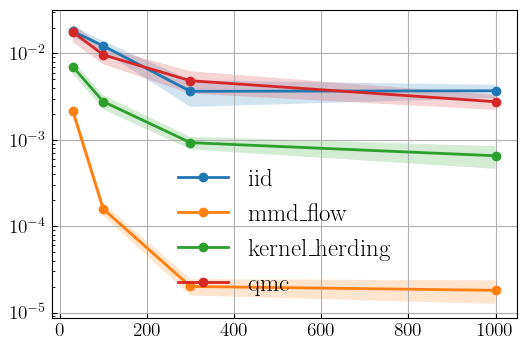

In [10]:
fig1 = plt.figure(figsize=(6, 4))
plt.grid(True)

plt.plot(particle_num_list, I_err['iid'][0], label='iid', marker='o')
plt.fill_between(particle_num_list, I_err['iid'][0] - I_err['iid'][1], I_err['iid'][0] + I_err['iid'][1], alpha=0.2)
plt.plot(particle_num_list, I_err['mmd_flow'][0], label='mmd_flow', marker='o')
plt.fill_between(particle_num_list, I_err['mmd_flow'][0] - I_err['mmd_flow'][1], I_err['mmd_flow'][0] + I_err['mmd_flow'][1], alpha=0.2)
plt.plot(particle_num_list, I_err['kh'][0], label='kernel_herding', marker='o')
plt.fill_between(particle_num_list, I_err['kh'][0] - I_err['kh'][1], I_err['kh'][0] + I_err['kh'][1], alpha=0.2)
plt.plot(particle_num_list, I_err['qmc'][0], label='qmc', marker='o')
plt.fill_between(particle_num_list, I_err['qmc'][0] - I_err['qmc'][1], I_err['qmc'][0] + I_err['qmc'][1], alpha=0.2)
plt.yscale('log')
plt.legend()
plt.show()